In [1]:
import yaml, os, uproot

with open('../../src/parameters/cross-section.yaml', 'r', encoding='utf-8') as f:
    cross_section_baseline = yaml.safe_load(f)['ZpToHG']

# convert pb to fb
cross_section_baseline = {k: v*1e3 for k, v in cross_section_baseline.items()}


cross_section_baseline

{'ZpToHGamma_M600': 47.199999999999996,
 'ZpToHGamma_M700': 37.87,
 'ZpToHGamma_M800': 30.52,
 'ZpToHGamma_M900': 24.68,
 'ZpToHGamma_M1000': 20.11,
 'ZpToHGamma_M1200': 13.5,
 'ZpToHGamma_M1400': 9.228,
 'ZpToHGamma_M1600': 6.37,
 'ZpToHGamma_M1800': 4.422,
 'ZpToHGamma_M2000': 3.093,
 'ZpToHGamma_M2200': 2.16,
 'ZpToHGamma_M2400': 1.51,
 'ZpToHGamma_M2600': 1.057,
 'ZpToHGamma_M3000': 0.5056,
 'ZpToHGamma_M3500': 0.1897}

In [11]:
rate_limit = {'SR1': {}, 'SR2': {}}
for file in os.listdir('.'):
    if file.startswith('higgsCombinef') and file.endswith('.root'):
        mass, SR = file.split('.')[1].split('_')
        mass = int(mass)
        limit = uproot.open(file)['limit']['limit'].array()
        rate_limit[SR][mass] = {
            'Expected -2sigma': limit[0],
            'Expected -1sigma': limit[1],
            'Expected Limit': limit[2],
            'Expected +1sigma': limit[3],
            'Expected +2sigma': limit[4],
            'Observed Limit': limit[5]
        }

In [12]:
rate_limit

{'SR1': {900: {'Expected -2sigma': 0.1022186279296875,
   'Expected -1sigma': 0.13897764682769775,
   'Expected Limit': 0.1982421875,
   'Expected +1sigma': 0.28516438603401184,
   'Expected +2sigma': 0.39436039328575134,
   'Observed Limit': 0.1725189112350897},
  1000: {'Expected -2sigma': 0.09466552734375,
   'Expected -1sigma': 0.12801361083984375,
   'Expected Limit': 0.18359375,
   'Expected +1sigma': 0.2662885785102844,
   'Expected +2sigma': 0.3700830340385437,
   'Observed Limit': 0.3068625448566291},
  1200: {'Expected -2sigma': 0.09325218200683594,
   'Expected -1sigma': 0.12767958641052246,
   'Expected Limit': 0.18505859375,
   'Expected +1sigma': 0.2721014618873596,
   'Expected +2sigma': 0.38563063740730286,
   'Observed Limit': 0.2690004063624584},
  1400: {'Expected -2sigma': 0.1028594970703125,
   'Expected -1sigma': 0.1426563262939453,
   'Expected Limit': 0.208984375,
   'Expected +1sigma': 0.31311196088790894,
   'Expected +2sigma': 0.45289346575737,
   'Observed L

In [19]:
with open('./rate_limit.yaml', 'w', encoding='utf-8') as f:
    yaml.dump(rate_limit, f)

In [28]:
cross_section_limit = {
    SR: {
        mass: {
            limit: rate_limit[SR][mass][limit] * cross_section_baseline[f'ZpToHGamma_M{mass}'] for limit in rate_limit[SR][mass]
        } for mass in rate_limit[SR]
    } for SR in rate_limit
}
cross_section_limit['SR1'][700]['Expected Limit'], cross_section_limit['SR2'][700]['Expected Limit']

(24.63029296875, 8.87578125)

In [29]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
import numpy as np

use_helvet = True ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

def plot_cross_section_limit(cross_section_limit, x_name: str, SR: str, cuts=None, year='2018', x_min=500, x_max=3800):
    LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83,}
    LUMI["Run 2"] = np.sum(list(LUMI.values()))
    if cuts:
        arrays = {k: v[cuts[k]] for k, v in arrays.items()}

    ## canvas initializing
    # colorlist=['red', 'blue', 'green', 'black', 'cyan', 'darkorange', 'darkviolet', 'SlateGray', 'HotPink', 'LightSkyBlue']
    # mpl.rcParams['axes.prop_cycle'] = cycler(color=colorlist)
    f = plt.figure(figsize=(9, 9))
    ax = plt.gca()
    plt.grid()
    hep.cms.label(data=False, ax=ax, fontsize=18, year=year, lumi=LUMI[year])
    
    ## analyze

        
    ## plot
    # mpl.rcParams['axes.prop_cycle'] = cycler(color=['red', 'blue', 'green', 'darkorange', 'cyan', 'HotPink', 'darkviolet', 'SlateGray', 'black', 'LightSkyBlue'])
    x = list(cross_section_limit.keys())
    expected_center = np.array([cross_section_limit[m]['Expected Limit'] for m in x])
    
    ax.scatter(
        x=x, y=[cross_section_limit[m]['Observed Limit'] for m in x], color='black', label='Observed limit (on pseudo-data)', marker='o', s=72
    )
    ax.errorbar(
        x=x, y=expected_center,
        yerr=[expected_center-np.array([cross_section_limit[m]['Expected -2sigma'] for m in x]), np.array([cross_section_limit[m]['Expected +2sigma'] for m in x])-expected_center],
        label=r'Expected limit $\pm 2\sigma$', linestyle='', linewidth=3, marker='o', markeredgecolor='black', markerfacecolor='white', ecolor='darkorange'
    )
    ax.errorbar(
        x=x, y=expected_center,
        yerr=[expected_center-np.array([cross_section_limit[m]['Expected -1sigma'] for m in x]), np.array([cross_section_limit[m]['Expected +1sigma'] for m in x])-expected_center],
        label=r'Expected limit $\pm 1\sigma$', linestyle='', linewidth=3, marker='o', markeredgecolor='black', markerfacecolor='white', ecolor='green'
    )
    # or you can specify color='blue' in the above function to cover colorlist (you could comment out colorlist too) 

    ## axises
    ax.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(1e-2, ax.get_ylim()[1]*5)
    ax.set_yscale('log')
    #ax.ticklabel_format(useOffset=False, style='scientific')
    ax.tick_params(axis='both', which='major', labelsize=16)
    #x_major_locator=plt.MultipleLocator(bin_width*8 if variable=='fj_gen_mass' else bin_width*2)
    #y_major_locator=MultipleLocator(1)
    #ax.xaxis.set_major_locator(x_major_locator)
    #ax.yaxis.set_major_locator(y_major_locator)
    ax.set_ylabel('95% CL upper limit on '+r'$\sigma[Z^\mathrm{\prime}\to H\gamma]$ (fb)', fontsize=20, ha='right', y=1)

    plt.xticks(size=16)
    plt.yticks(size=16)

    ## title, text and legend
    # plt.title('ROC Curve of HWW4q vs. QCD', fontsize=24,color="black")
    ax.legend(loc="best", ncol=1, frameon=False, fontsize=22)
    # plt.text(0.96*ax.get_xlim()[1], ax.get_ylim()[1]*0.72,"At "+r"$\mathrm{m^{gen}_{H}=}$"+f"{Higgsmass} GeV", fontsize=24, color="black", ha='right')

    ## finalizing
    if not os.path.exists(f'../plots/fit/{year}'):
        os.makedirs(f'../plots/fit/{year}')
    plt.savefig(f"../plots/fit/{year}/{SR}_limit.pdf", bbox_inches='tight')
    plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the foll

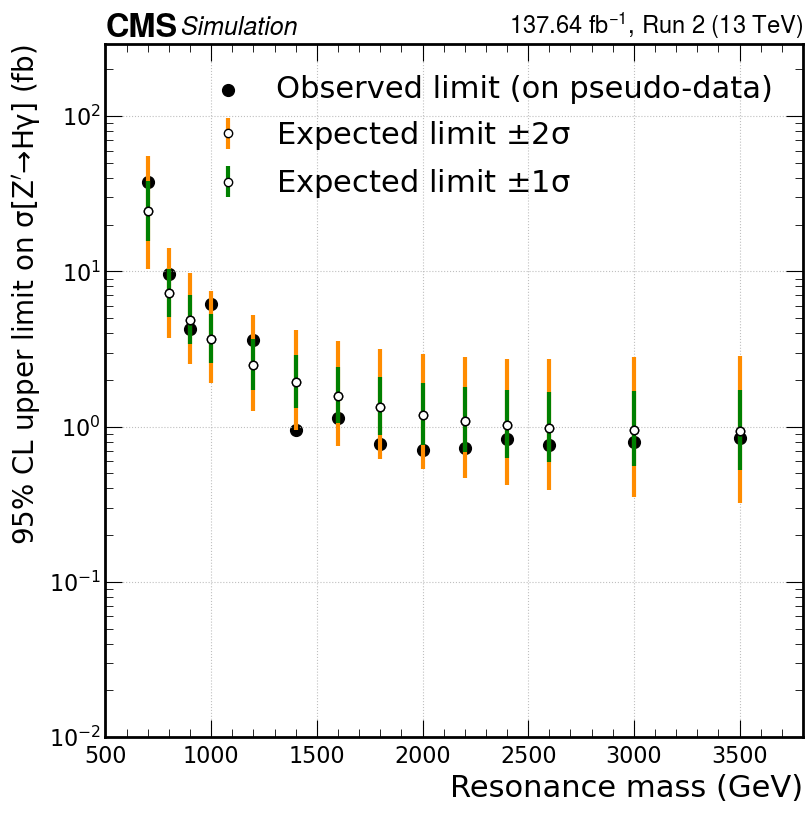

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the foll

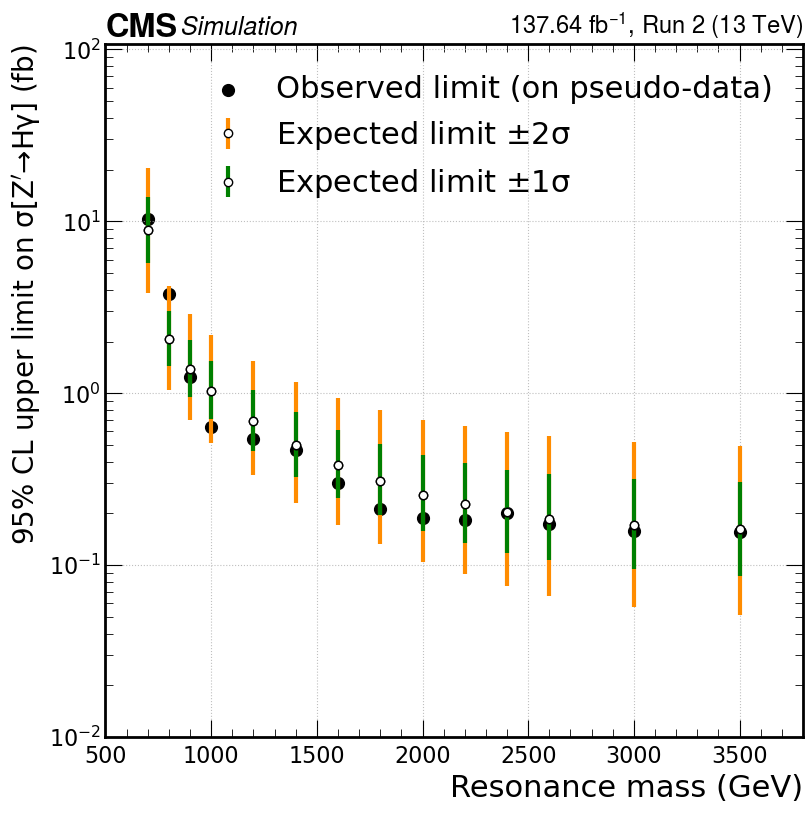

In [30]:
for SR in ('SR1', 'SR2'):
    plot_cross_section_limit(cross_section_limit=cross_section_limit[SR], x_name='Resonance mass (GeV)', year='Run 2', SR=SR)